# ResNet

在 **ResNet（Residual Network, 残差网络）** 提出之前，深度卷积神经网络（CNN）面临一个关键问题：**随着网络层数的增加，模型的性能不升反降**。这种现象被称为**退化问题（Degradation Problem）**，即更深的网络在训练集和测试集上的表现反而比浅层网络更差。

传统观点认为，更深的网络可以学习更复杂的特征，但实验表明，深层网络的优化难度显著增加，梯度消失/爆炸（尽管通过BatchNorm缓解了部分问题）和网络退化成为主要瓶颈。2015年，何恺明团队提出的**ResNet**（CVPR 2016最佳论文）通过引入**残差连接（Residual Connection）**，成功训练了超过1000层的网络，并在ImageNet分类任务上取得突破性进展（Top-5错误率降至3.57%）。

**ResNet解决的核心问题**：
- **梯度传播难题**：通过残差结构，梯度可以直接绕过非线性层回传，缓解梯度消失。
- **网络退化**：即使深层网络的额外层恒等映射（Identity Mapping），性能也不应比浅层网络差，残差结构确保了这一点。

---

### 创新性
- **残差学习（Residual Learning）**  
  传统网络直接学习目标函数 $ H(x)$，而ResNet改为学习残差 $ F(x) = H(x) - x $，并通过跳跃连接（Shortcut Connection）实现 $H(x) = F(x) + x$。这种设计使得网络更容易学习微小变化（如恒等映射时 $F(x) \to 0$）。

  ![alt text](resources/residual_connection.png "Title")
  
- **Bottleneck结构**  
  在深层ResNet（如ResNet-50/101）中，使用1×1卷积先降维再升维，减少计算量（如3×3卷积的输入/输出通道数降低）。

### 对当代CNN的影响
- **成为深度网络的标配**  
  ResNet的残差结构被广泛应用于几乎所有现代CNN架构（如DenseNet、MobileNetV2、EfficientNet等），成为构建深层模型的基础组件。
  
- **推动网络深度飞跃**  
  ResNet-152（2015年）的提出证明了极深网络的可行性，后续研究（如ResNeXt、Res2Net）进一步优化了残差模块的设计。
  
- **跨领域应用**  
  残差思想被迁移到其他架构（如Transformer中的残差连接、U-Net的跳跃连接），甚至影响了非神经网络模型（如残差强化学习）。


ResNet通过简单的残差连接解决了深层网络的训练难题，成为深度学习史上的里程碑。其设计哲学（“让网络更容易学习恒等映射”）启发了后续大量研究，至今仍是计算机视觉和其他领域的核心架构之一。

  ![alt text](resources/resnet_arch.png "Title")

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader

TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomRotation(10),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=train_dataset_transforms,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=val_dataset_transforms,
)


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader

## 测试比较不同的Resnet架构

In [3]:
from spacy import training
from hdd.models.cnn.resnet import Resnet, resnet18_config
from hdd.train.early_stopping import EarlyStoppingInMem
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    resnet_config,
    train_dataloader,
    val_dataloader,
    dropout,
    lr,
    weight_decay,
    step_size=30,
    gamma=0.5,
    patience=30,
    max_epochs=150,
) -> tuple[Resnet, dict[str, list[float]]]:
    net = Resnet(resnet_config, num_classes=10, dropout=dropout).to(DEVICE)
    criteria = nn.CrossEntropyLoss()
    # SGD的效果远不如Adam好
    # optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.AdamW(
        net.parameters(), lr=lr, eps=1e-6, weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=step_size, gamma=gamma, last_epoch=-1
    )
    early_stopper = EarlyStoppingInMem(patience=patience, verbose=False)
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        early_stopper,
        verbose=True,
    )
    return net, training_stats


train_dataloader, val_dataloader = build_dataloader(128, train_dataset, val_dataset)
net, resnet18_stats = train_net(
    resnet18_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-4,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/150 Train Loss: 1.9133 Accuracy: 0.3382 Time: 7.24565  | Val Loss: 1.8480 Accuracy: 0.3873
Epoch: 2/150 Train Loss: 1.6093 Accuracy: 0.4613 Time: 7.09541  | Val Loss: 2.0834 Accuracy: 0.3873
Epoch: 3/150 Train Loss: 1.3935 Accuracy: 0.5401 Time: 7.05743  | Val Loss: 2.0390 Accuracy: 0.4117
Epoch: 4/150 Train Loss: 1.2248 Accuracy: 0.6039 Time: 7.08256  | Val Loss: 1.3004 Accuracy: 0.5934
Epoch: 5/150 Train Loss: 1.1614 Accuracy: 0.6230 Time: 7.02096  | Val Loss: 1.2646 Accuracy: 0.5952
Epoch: 6/150 Train Loss: 1.0868 Accuracy: 0.6572 Time: 7.51722  | Val Loss: 1.0496 Accuracy: 0.6685
Epoch: 7/150 Train Loss: 0.9813 Accuracy: 0.6829 Time: 7.08420  | Val Loss: 0.9686 Accuracy: 0.6930
Epoch: 8/150 Train Loss: 0.9388 Accuracy: 0.7013 Time: 6.98512  | Val Loss: 0.9658 Accuracy: 0.6859
Epoch: 9/150 Train Loss: 0.9012 Accuracy: 0.7107 Time: 7.03298  | Val Loss: 0.7795 Accuracy: 0.7536
Epoch: 10/150 Train Loss: 0.8494 Accuracy: 0.7307 Time: 7.34997  | Val Loss: 1.0847 Accuracy: 0.6757

In [4]:
from hdd.models.cnn.resnet import resnet34_config

train_dataloader, val_dataloader = build_dataloader(128, train_dataset, val_dataset)
net, resnet34_stats = train_net(
    resnet34_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-4,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/150 Train Loss: 1.8986 Accuracy: 0.3413 Time: 9.69959  | Val Loss: 1.8952 Accuracy: 0.3969
Epoch: 2/150 Train Loss: 1.5854 Accuracy: 0.4682 Time: 9.71893  | Val Loss: 1.5856 Accuracy: 0.4703
Epoch: 3/150 Train Loss: 1.4127 Accuracy: 0.5391 Time: 9.69183  | Val Loss: 1.3682 Accuracy: 0.5559
Epoch: 4/150 Train Loss: 1.2494 Accuracy: 0.5989 Time: 9.70857  | Val Loss: 1.1710 Accuracy: 0.6262
Epoch: 5/150 Train Loss: 1.1400 Accuracy: 0.6293 Time: 9.68955  | Val Loss: 1.0006 Accuracy: 0.6752
Epoch: 6/150 Train Loss: 1.0561 Accuracy: 0.6626 Time: 9.69012  | Val Loss: 1.1600 Accuracy: 0.6380
Epoch: 7/150 Train Loss: 0.9957 Accuracy: 0.6835 Time: 9.69107  | Val Loss: 0.9895 Accuracy: 0.6797
Epoch: 8/150 Train Loss: 0.9502 Accuracy: 0.6982 Time: 9.68394  | Val Loss: 1.3597 Accuracy: 0.5715
Epoch: 9/150 Train Loss: 0.9099 Accuracy: 0.7111 Time: 9.68502  | Val Loss: 0.9546 Accuracy: 0.6907
Epoch: 10/150 Train Loss: 0.8396 Accuracy: 0.7315 Time: 9.68136  | Val Loss: 0.9914 Accuracy: 0.7062

In [5]:
from hdd.models.cnn.resnet import resnet50_config

train_dataloader, val_dataloader = build_dataloader(128, train_dataset, val_dataset)
net, resnet50_stats = train_net(
    resnet50_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-4,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/150 Train Loss: 2.3594 Accuracy: 0.2090 Time: 15.81821  | Val Loss: 2.0423 Accuracy: 0.2601
Epoch: 2/150 Train Loss: 1.9640 Accuracy: 0.3032 Time: 15.79861  | Val Loss: 1.9277 Accuracy: 0.3233
Epoch: 3/150 Train Loss: 1.7646 Accuracy: 0.3866 Time: 15.80088  | Val Loss: 1.9916 Accuracy: 0.3246
Epoch: 4/150 Train Loss: 1.6305 Accuracy: 0.4353 Time: 15.81049  | Val Loss: 1.5092 Accuracy: 0.4920
Epoch: 5/150 Train Loss: 1.5343 Accuracy: 0.4850 Time: 15.82453  | Val Loss: 1.3905 Accuracy: 0.5348
Epoch: 6/150 Train Loss: 1.3993 Accuracy: 0.5357 Time: 15.76372  | Val Loss: 1.4614 Accuracy: 0.5218
Epoch: 7/150 Train Loss: 1.3413 Accuracy: 0.5578 Time: 15.79463  | Val Loss: 1.1937 Accuracy: 0.6239
Epoch: 8/150 Train Loss: 1.2444 Accuracy: 0.5929 Time: 15.80908  | Val Loss: 1.2835 Accuracy: 0.5763
Epoch: 9/150 Train Loss: 1.1787 Accuracy: 0.6167 Time: 15.77034  | Val Loss: 1.3170 Accuracy: 0.5890
Epoch: 10/150 Train Loss: 1.0864 Accuracy: 0.6461 Time: 15.77599  | Val Loss: 1.0829 Accura

In [6]:
from hdd.models.cnn.resnet import resnet101_config

train_dataloader, val_dataloader = build_dataloader(64, train_dataset, val_dataset)
net, resnet101_stats = train_net(
    resnet101_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-4,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/150 Train Loss: 2.2768 Accuracy: 0.2093 Time: 22.25189  | Val Loss: 1.9750 Accuracy: 0.2978
Epoch: 2/150 Train Loss: 1.9252 Accuracy: 0.3164 Time: 21.88997  | Val Loss: 1.8041 Accuracy: 0.3613
Epoch: 3/150 Train Loss: 1.7651 Accuracy: 0.4007 Time: 21.85791  | Val Loss: 1.7169 Accuracy: 0.3959
Epoch: 4/150 Train Loss: 1.5691 Accuracy: 0.4754 Time: 21.85783  | Val Loss: 1.4929 Accuracy: 0.4899
Epoch: 5/150 Train Loss: 1.4460 Accuracy: 0.5213 Time: 21.81843  | Val Loss: 1.3184 Accuracy: 0.5498
Epoch: 6/150 Train Loss: 1.3004 Accuracy: 0.5723 Time: 21.79397  | Val Loss: 1.2944 Accuracy: 0.5929
Epoch: 7/150 Train Loss: 1.2380 Accuracy: 0.5954 Time: 21.78773  | Val Loss: 1.1197 Accuracy: 0.6367
Epoch: 8/150 Train Loss: 1.1545 Accuracy: 0.6297 Time: 21.87923  | Val Loss: 1.3805 Accuracy: 0.5857
Epoch: 9/150 Train Loss: 1.0925 Accuracy: 0.6503 Time: 21.79546  | Val Loss: 0.9452 Accuracy: 0.6935
Epoch: 10/150 Train Loss: 1.0161 Accuracy: 0.6784 Time: 21.84323  | Val Loss: 1.0783 Accura

In [7]:
from hdd.models.cnn.resnet import resnet150_config

train_dataloader, val_dataloader = build_dataloader(64, train_dataset, val_dataset)
net, resnet150_stats = train_net(
    resnet150_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-4,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/150 Train Loss: 2.3874 Accuracy: 0.1823 Time: 29.39404  | Val Loss: 2.0808 Accuracy: 0.2224
Epoch: 2/150 Train Loss: 2.0540 Accuracy: 0.2553 Time: 29.43147  | Val Loss: 1.8572 Accuracy: 0.3297
Epoch: 3/150 Train Loss: 1.8562 Accuracy: 0.3443 Time: 29.51494  | Val Loss: 1.8000 Accuracy: 0.3572
Epoch: 4/150 Train Loss: 1.7521 Accuracy: 0.3837 Time: 29.46161  | Val Loss: 1.8238 Accuracy: 0.3811
Epoch: 5/150 Train Loss: 1.6573 Accuracy: 0.4258 Time: 29.51271  | Val Loss: 1.7863 Accuracy: 0.3842
Epoch: 6/150 Train Loss: 1.5714 Accuracy: 0.4678 Time: 29.45594  | Val Loss: 1.3881 Accuracy: 0.5417
Epoch: 7/150 Train Loss: 1.4538 Accuracy: 0.5159 Time: 29.42910  | Val Loss: 1.5601 Accuracy: 0.4894
Epoch: 8/150 Train Loss: 1.3833 Accuracy: 0.5438 Time: 29.42076  | Val Loss: 1.2751 Accuracy: 0.5918
Epoch: 9/150 Train Loss: 1.2972 Accuracy: 0.5774 Time: 29.44181  | Val Loss: 1.0998 Accuracy: 0.6487
Epoch: 10/150 Train Loss: 1.2330 Accuracy: 0.5971 Time: 29.43030  | Val Loss: 1.1870 Accura

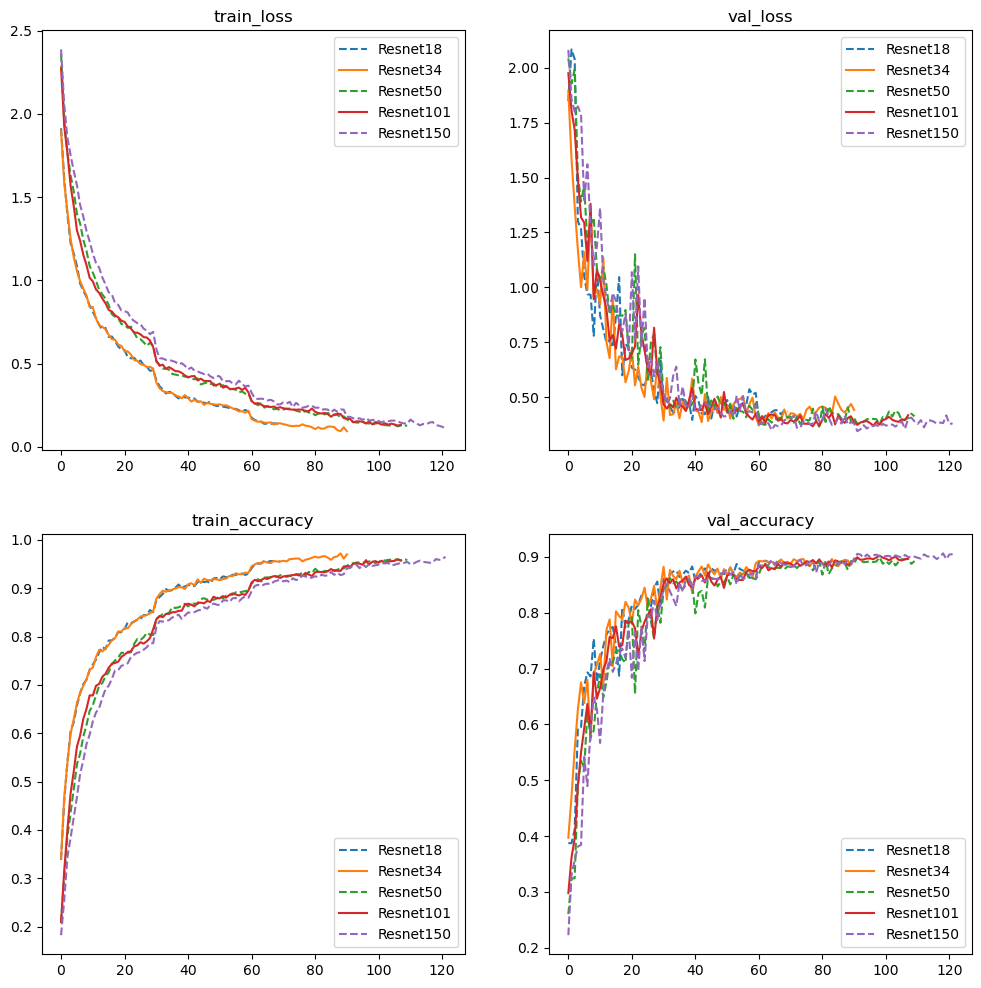

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = resnet18_stats.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(resnet18_stats[field], label="Resnet18", linestyle="--")
    plt.plot(resnet34_stats[field], label="Resnet34")
    plt.plot(resnet50_stats[field], label="Resnet50", linestyle="--")
    plt.plot(resnet101_stats[field], label="Resnet101")
    plt.plot(resnet150_stats[field], label="Resnet150", linestyle="--")
    plt.legend()
    plt.title(field)